In [1]:
from helper.dataset_reader import read_tsv
from helper.data_transformer import *
from langid_crf import *
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, classification_report, make_scorer
from sklearn_crfsuite import metrics

In [2]:
langid = LanguageIdentifier()

In [3]:
raw_data = read_tsv('../dataset/comlid-data-140422-v1.tsv')
data = to_token_tag_list(raw_data)
X = [langid.sent2features(s) for s in data]
y = [langid.sent2tags(s) for s in data]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

In [4]:
len(X_train)

3613

In [5]:
len(X_test)

1781

### CRF Training

In [6]:
model = sklearn_crfsuite.CRF(
	algorithm='lbfgs',
	max_iterations=100,
	all_possible_transitions=True,
	c1=0.04077752338043632,
	c2=0.08790533946499102,
)

In [7]:
# train CRF
%time
model.fit(X_train, y_train)

CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 7.87 µs


CRF(algorithm='lbfgs', all_possible_transitions=True, c1=0.04077752338043632,
    c2=0.08790533946499102, keep_tempfiles=None, max_iterations=100)

In [8]:
y_pred = model.predict(X_test)

In [9]:
# save model
model_name = 'crf_model.pkl'
root_path = 'model/'
joined_path = os.path.join(root_path, model_name)
pickle.dump(model, open(joined_path, 'wb'))


 Evaluation on the test data
Confusion Matrix
              precision    recall  f1-score   support

          ID       0.95      0.97      0.96     22315
          JV       0.91      0.91      0.91      4911
          EN       0.93      0.92      0.92      5006
   MIX-ID-EN       0.95      0.90      0.93       975
   MIX-ID-JV       0.96      0.88      0.92       289
   MIX-JV-EN       0.94      0.86      0.90       274
           O       0.97      0.92      0.94     10167

    accuracy                           0.95     43937
   macro avg       0.94      0.91      0.93     43937
weighted avg       0.95      0.95      0.95     43937



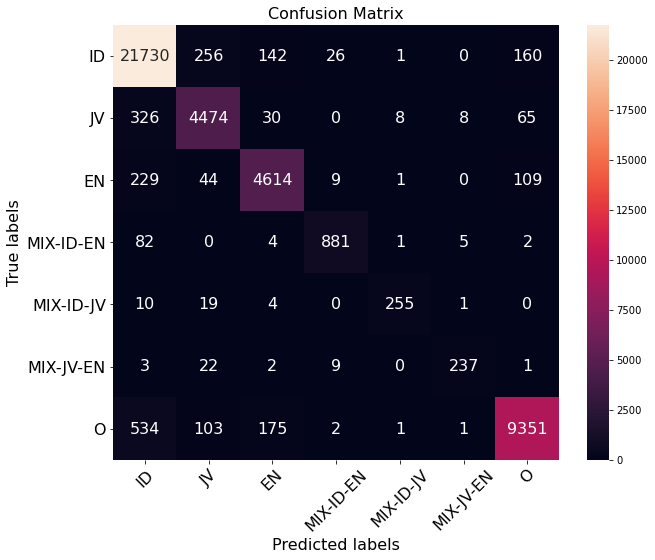

In [10]:
print('\n Evaluation on the test data')
langid.show_confusion_matrix(y_test, y_pred)

# increase font of x and y axis

In [11]:
print("\nTop likely transitions:")
langid.print_transitions(Counter(model.transition_features_).most_common(20))
print("\nTop unlikely transitions:")
langid.print_transitions(Counter(model.transition_features_).most_common()[-20:])

# check the state features
print("\nTop positive:")
langid.print_state_features(Counter(model.state_features_).most_common(20))
print("\nTop negative:")
langid.print_state_features(Counter(model.state_features_).most_common()[-20:])


Top likely transitions:
O          -> O          0.93391
O          -> ID         0.80029
O          -> JV         0.76042
ID         -> O          0.75662
JV         -> O          0.60744
O          -> EN         0.60625
EN         -> O          0.60015
EN         -> EN         0.43206
JV         -> JV         0.40043
ID         -> ID         0.26418
MIX-JV-EN  -> O          0.01398
ID         -> EN         0.00831
JV         -> MIX-JV-EN  -0.03427
JV         -> MIX-ID-JV  -0.06796
MIX-ID-EN  -> O          -0.07723
EN         -> ID         -0.10273
MIX-ID-JV  -> JV         -0.15558
O          -> MIX-ID-JV  -0.16206
O          -> MIX-ID-EN  -0.19504
MIX-ID-JV  -> O          -0.19734

Top unlikely transitions:
O          -> MIX-JV-EN  -0.41954
MIX-JV-EN  -> MIX-JV-EN  -0.43180
MIX-ID-JV  -> MIX-JV-EN  -0.44870
EN         -> MIX-ID-EN  -0.48997
MIX-ID-JV  -> ID         -0.52897
ID         -> MIX-ID-JV  -0.53401
MIX-JV-EN  -> EN         -0.59939
MIX-ID-JV  -> EN         -0.63903
MIX-ID-E

In [12]:
import eli5

eli5.show_weights(model,horizontal_layout=False, show=['transition_features'])

From \ To,EN,ID,JV,MIX-ID-EN,MIX-ID-JV,MIX-JV-EN,O
EN,0.432,-0.103,-0.38,-0.49,-1.032,-0.416,0.6
ID,0.008,0.264,-0.276,-0.202,-0.534,-0.811,0.757
JV,-0.295,-0.307,0.4,-1.53,-0.068,-0.034,0.607
MIX-ID-EN,-0.419,-0.352,-1.241,-0.752,-0.848,-1.481,-0.077
MIX-ID-JV,-0.639,-0.529,-0.156,-3.454,-1.055,-0.449,-0.197
MIX-JV-EN,-0.599,-0.77,-0.237,-1.079,-1.051,-0.432,0.014
O,0.606,0.8,0.76,-0.195,-0.162,-0.42,0.934


In [13]:
eli5.show_weights(model, targets=['ID','EN','JV'])

In [14]:
eli5.show_weights(model, targets=['MIX-ID-EN','MIX-ID-JV','MIX-JV-EN','O'])

In [15]:
## Error Analysis
crf_model = pickle.load(open('model/crf_model.pkl','rb'))